In [136]:
from pyspark.sql import SparkSession    
spark = SparkSession \
        .builder \
        .appName("Python Spark Data Exploration") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [137]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').load("german_credit.csv",header=True);

In [138]:
df.columns

['Creditability',
 'Account Balance',
 'Duration of Credit (month)',
 'Payment Status of Previous Credit',
 'Purpose',
 'Credit Amount',
 'Value Savings/Stocks',
 'Length of current employment',
 'Instalment per cent',
 'Sex & Marital Status',
 'Guarantors',
 'Duration in Current address',
 'Most valuable available asset',
 'Age (years)',
 'Concurrent Credits',
 'Type of apartment',
 'No of Credits at this Bank',
 'Occupation',
 'No of dependents',
 'Telephone',
 'Foreign Worker']

In [139]:
df[['Account Balance','No of dependents']].toPandas().describe()

,Account Balance,No of dependents
count,1000.000000,1000.000000
mean,2.577000,1.155000
std,1.257638,0.362086
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,4.000000,1.000000
max,4.000000,2.000000


In [140]:
def describe_pd(df_in, columns, style):
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe 
    :param columns: the cloumn name list of the numerical variable     
    :param style: the display style  

    :return : the numerical describe info. of the input dataframe   

    :author: Wenqiang Feng
    :email:  von198@gmail.com  
    '''       

    if style == 1:
        percentiles = [25, 50, 75]
    else:
        percentiles = np.array(range(0, 110, 10))
    
    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]
    
    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [141]:
# selected varables for the demonstration
num_cols = ['Account Balance','No of dependents']

In [142]:
df.select(num_cols).describe().show()

+-------+------------------+-------------------+
|summary|   Account Balance|   No of dependents|
+-------+------------------+-------------------+
|  count|              1000|               1000|
|   mean|             2.577|              1.155|
| stddev|1.2576377271108936|0.36208577175319395|
|    min|                 1|                  1|
|    max|                 4|                  2|
+-------+------------------+-------------------+



In [143]:
output = describe_pd(df,num_cols,1)

In [144]:
output['summary']= output['summary'].astype(str)
# convert just columns
output[num_cols] = output[num_cols].apply(pd.to_numeric)

In [145]:
output.dtypes

summary              object
Account Balance     float64
No of dependents    float64
dtype: object

In [146]:
spark.createDataFrame(output).show()

+-------+------------------+-----------------+
|summary|   Account Balance| No of dependents|
+-------+------------------+-----------------+
|  count|            1000.0|           1000.0|
|   mean|             2.577|            1.155|
| stddev|1.2576377271108936|0.362085771753194|
|    min|               1.0|              1.0|
|    max|               4.0|              2.0|
|    25%|               1.0|              1.0|
|    50%|               2.0|              1.0|
|    75%|               4.0|              1.0|
+-------+------------------+-----------------+



In [147]:
output = describe_pd(df,num_cols,2)

In [148]:
output['summary']= output['summary'].astype(str)
# convert just columns
output[num_cols] = output[num_cols].apply(pd.to_numeric)
spark.createDataFrame(output).show()

+-------+------------------+-----------------+
|summary|   Account Balance| No of dependents|
+-------+------------------+-----------------+
|  count|            1000.0|           1000.0|
|   mean|             2.577|            1.155|
| stddev|1.2576377271108936|0.362085771753194|
|    min|               1.0|              1.0|
|    max|               4.0|              2.0|
|     0%|               1.0|              1.0|
|    10%|               1.0|              1.0|
|    20%|               1.0|              1.0|
|    30%|               2.0|              1.0|
|    40%|               2.0|              1.0|
|    50%|               2.0|              1.0|
|    60%|               3.0|              1.0|
|    70%|               4.0|              1.0|
|    80%|               4.0|              1.0|
|    90%|               4.0|              2.0|
|   100%|               4.0|              2.0|
+-------+------------------+-----------------+



In [149]:
df.select('Credit Amount').show(5)

+-------------+
|Credit Amount|
+-------------+
|         1049|
|         2799|
|          841|
|         2122|
|         2171|
+-------------+
only showing top 5 rows



In [150]:
data1 = df.select('Age (years)').toPandas()

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

plt.rcParams['figure.figsize'] =(16,9)
plt.style.use('ggplot')
sns.set()

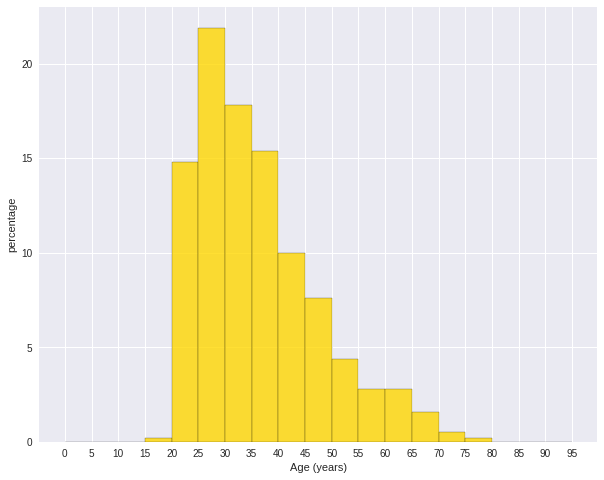

In [152]:
var = 'Age (years)'
x = data1[var]
bins = np.arange(0, 100, 5.0)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(x, bins, alpha=0.8, histtype='bar', color='gold',
         ec='black',weights=np.zeros_like(x) + 100. / x.size)

plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

fig.savefig(var+".pdf", bbox_inches='tight')

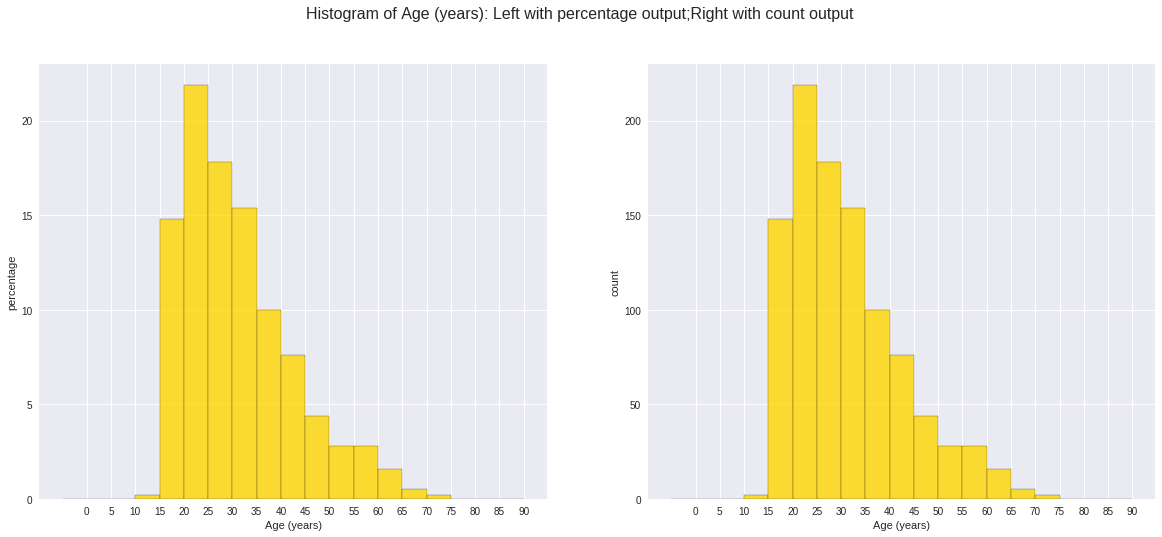

In [153]:
var = 'Age (years)'
x = data1[var]
bins = np.arange(0, 100, 5.0)


########################################################################
hist, bin_edges = np.histogram(x,bins,
                               weights=np.zeros_like(x) + 100. / x.size) 
# make the histogram
 
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)

# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1,alpha=0.8,ec ='black', color='gold')
# # Set the ticks to the middle of the bars
ax.set_xticks([0.5+i for i,j in enumerate(hist)]) 
# Set the xticklabels to a string that tells us what the bin edges were
labels =['{}'.format(int(bins[i+1])) for i,j in enumerate(hist)]
labels.insert(0,'0')
ax.set_xticklabels(labels)
plt.xlabel(var)
plt.ylabel('percentage')

########################################################################

hist, bin_edges = np.histogram(x,bins) # make the histogram

ax = fig.add_subplot(1, 2, 2)
# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1,alpha=0.8,ec ='black', color='gold')
 
# # Set the ticks to the middle of the bars
ax.set_xticks([0.5+i for i,j in enumerate(hist)])
 
# Set the xticklabels to a string that tells us what the bin edges were
labels =['{}'.format(int(bins[i+1])) for i,j in enumerate(hist)]
labels.insert(0,'0')
ax.set_xticklabels(labels)
plt.xlabel(var)
plt.ylabel('count')
plt.suptitle('Histogram of {}: Left with percentage output;Right with count output'
             .format(var), size=16)
plt.show()

fig.savefig(var+".pdf", bbox_inches='tight')

In [154]:
from pyspark.sql.functions import col, skewness, kurtosis

In [155]:
df.select(skewness(var),kurtosis(var)).show()

+---------------------+---------------------+
|skewness(Age (years))|kurtosis(Age (years))|
+---------------------+---------------------+
|   1.0231743160548064|   0.6114371688367672|
+---------------------+---------------------+



In [156]:
def age_condition(x):
    if pd.isnull(x):
        return "missing"
    elif x <25:
        return "<25"
    elif 25 <= x <= 34:
        return "25-34"
    elif 35 <= x <= 44:
        return "35-44" 
    elif 45 <= x <= 54:
        return "45-54" 
    elif 55 <= x <= 64:
        return "55-64"     
    else:
        return "65+"

In [157]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

age_udf = udf(lambda x: age_condition(x), StringType())

In [158]:
df = df.withColumn("age_class", age_udf("Age (years)"))

In [11]:
df.select(['age_class','Age (years)']).show(3)

+---------+-----------+
|age_class|Age (years)|
+---------+-----------+
|      <25|         21|
|    35-44|         36|
|      <25|         23|
+---------+-----------+
only showing top 3 rows



In [159]:
df.select(['age_class','Credit Amount']).\
   groupBy('age_class').count().show()

+---------+-----+
|age_class|count|
+---------+-----+
|    45-54|  120|
|      <25|  150|
|    55-64|   56|
|    35-44|  254|
|    25-34|  397|
|      65+|   23|
+---------+-----+



In [160]:
df.stat.crosstab("age_class", "Occupation").show()

+--------------------+---+---+---+---+
|age_class_Occupation|  1|  2|  3|  4|
+--------------------+---+---+---+---+
|                 <25|  4| 34|108|  4|
|               55-64|  1| 15| 31|  9|
|               25-34|  7| 61|269| 60|
|               35-44|  4| 58|143| 49|
|                 65+|  5|  3|  6|  9|
|               45-54|  1| 29| 73| 17|
+--------------------+---+---+---+---+



In [13]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
# withColumn('Percent %',F.format_string("%5.0f%%\n",col('Credit_num')*100/col('total'))).\
tab = df.select(['age_class','Credit Amount']).\
   groupBy('age_class').\
   agg(F.count('Credit Amount').alias('Credit_num'),
       F.mean('Credit Amount').alias('Credit_avg'),
       F.min('Credit Amount').alias('Credit_min'),
       F.max('Credit Amount').alias('Credit_max')).\
   withColumn('total',sum(col('Credit_num')).over(window)).\
   withColumn('Percent',col('Credit_num')*100/col('total')).\
   drop(col('total'))

In [114]:
tab.show()

+---------+----------+------------------+----------+----------+-------+
|age_class|Credit_num|        Credit_avg|Credit_min|Credit_max|Percent|
+---------+----------+------------------+----------+----------+-------+
|    45-54|       120|3183.0666666666666|       338|     12612|   12.0|
|      <25|       150| 2970.733333333333|       276|     15672|   15.0|
|    55-64|        56| 3493.660714285714|       385|     15945|    5.6|
|    35-44|       254| 3403.771653543307|       250|     15857|   25.4|
|    25-34|       397| 3298.823677581864|       343|     18424|   39.7|
|      65+|        23|3210.1739130434785|       571|     14896|    2.3|
+---------+----------+------------------+----------+----------+-------+



In [14]:
plot_data = tab.toPandas() 
plot_data.sort_values('age_class')

,age_class,Credit_num,Credit_avg,Credit_min,Credit_max,Percent
4,25-34,397,3298.823678,343,18424,39.7
3,35-44,254,3403.771654,250,15857,25.4
0,45-54,120,3183.066667,338,12612,12.0
2,55-64,56,3493.660714,385,15945,5.6
5,65+,23,3210.173913,571,14896,2.3
1,<25,150,2970.733333,276,15672,15.0


In [15]:
custom_dict = {'<25': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4, '65+': 5}

In [16]:
plot_data['index']= plot_data['age_class'].replace(custom_dict)

In [17]:
plot_data.sort_values('index')

,age_class,Credit_num,Credit_avg,Credit_min,Credit_max,Percent,index
1,<25,150,2970.733333,276,15672,15.0,0
4,25-34,397,3298.823678,343,18424,39.7,1
3,35-44,254,3403.771654,250,15857,25.4,2
0,45-54,120,3183.066667,338,12612,12.0,3
2,55-64,56,3493.660714,385,15945,5.6,4
5,65+,23,3210.173913,571,14896,2.3,5


In [18]:
plot_data = plot_data.sort_values('index')

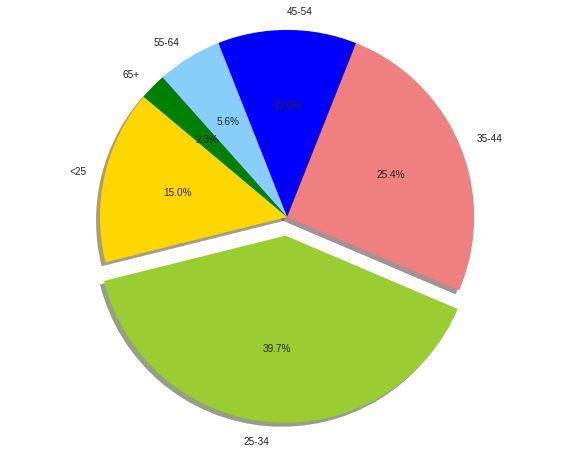

In [19]:
# Data to plot
labels = plot_data.age_class
sizes =  plot_data.Percent
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0, 0.1, 0, 0,0,0)  # explode 1st slice
 
# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

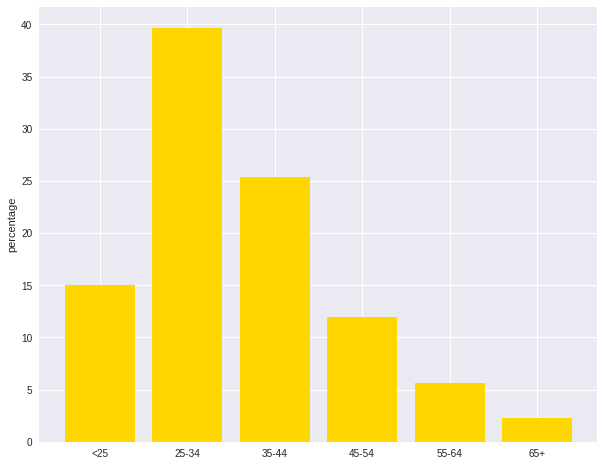

In [20]:
labels = plot_data.age_class
missing = plot_data.Percent
ind = [x for x, _ in enumerate(labels)]

plt.figure(figsize=(10,8))
plt.bar(ind, missing, width=0.8, label='missing', color='gold')

plt.xticks(ind, labels)
plt.ylabel("percentage")

plt.show()

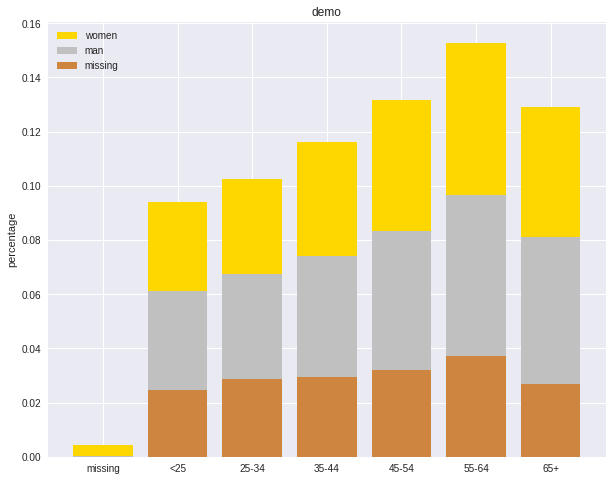

In [21]:
labels = ['missing', '<25', '25-34', '35-44', '45-54','55-64','65+']
missing = np.array([0.000095, 0.024830, 0.028665, 0.029477, 0.031918,0.037073,0.026699])
man = np.array([0.000147, 0.036311, 0.038684, 0.044761, 0.051269, 0.059542, 0.054259])
women = np.array([0.004035, 0.032935, 0.035351, 0.041778, 0.048437, 0.056236,0.048091])
ind = [x for x, _ in enumerate(labels)]

plt.figure(figsize=(10,8))
plt.bar(ind, women, width=0.8, label='women', color='gold', bottom=man+missing)
plt.bar(ind, man, width=0.8, label='man', color='silver', bottom=missing)
plt.bar(ind, missing, width=0.8, label='missing', color='#CD853F')

plt.xticks(ind, labels)
plt.ylabel("percentage")
plt.legend(loc="upper left")
plt.title("demo")

plt.show()

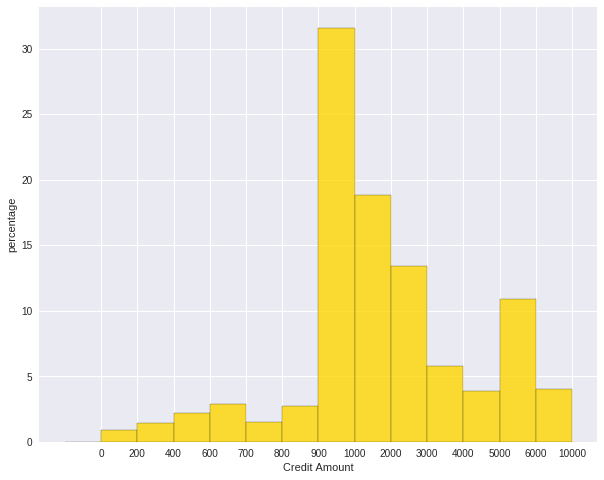

In [47]:
# prepare for the plot data

var = 'Credit Amount'
plot_data = df.select(var).toPandas()
x= plot_data[var]

bins =[0,200,400,600,700,800,900,1000,2000,3000,4000,5000,6000,10000,25000] 

hist, bin_edges = np.histogram(x,bins,weights=np.zeros_like(x) + 100. / x.size) # make the histogram
 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1,alpha=0.8,ec ='black',color = 'gold')
 
# # Set the ticks to the middle of the bars
ax.set_xticks([0.5+i for i,j in enumerate(hist)])
 
# Set the xticklabels to a string that tells us what the bin edges were
#labels =['{}k'.format(int(bins[i+1]/1000)) for i,j in enumerate(hist)]
labels =['{}'.format(bins[i+1]) for i,j in enumerate(hist)]
labels.insert(0,'0')
ax.set_xticklabels(labels)
#plt.text(-0.6, -1.4,'0')
plt.xlabel(var)
plt.ylabel('percentage')
plt.show()

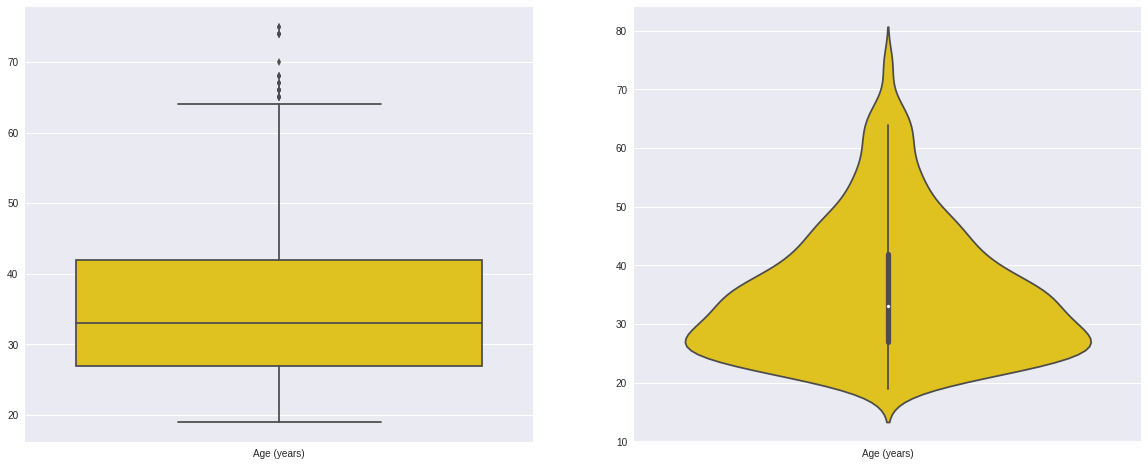

In [113]:
x = df.select(var).toPandas()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x,color='gold')

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data=x,color='gold')

In [117]:
corr_data = df.select(num_cols)

In [123]:
from pyspark.mllib.stat import Statistics
import pandas as pd

corr_data = df.select(num_cols)

col_names = corr_data.columns
features = corr_data.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

                  Account Balance  No of dependents
Account Balance          1.000000         -0.014145
No of dependents        -0.014145          1.000000


In [122]:
spark.createDataFrame(corr_df).show()

+--------------------+--------------------+
|     Account Balance|    No of dependents|
+--------------------+--------------------+
|                 1.0|-0.01414542650320914|
|-0.01414542650320914|                 1.0|
+--------------------+--------------------+



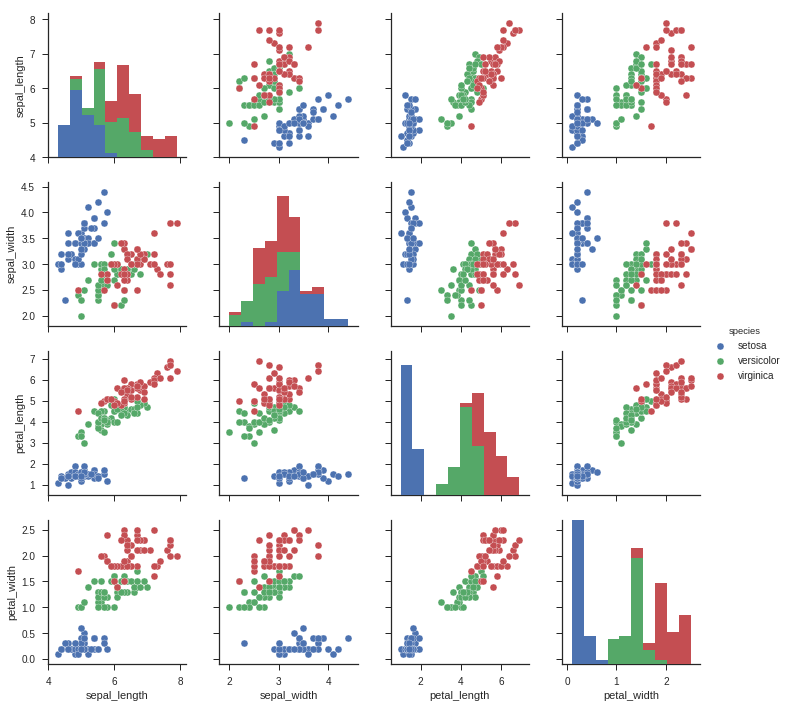

In [125]:
import seaborn as sns
sns.set(style="ticks")

df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")
plt.show()

In [119]:
print(corr_df.to_string())

                  Account Balance  No of dependents
Account Balance          1.000000         -0.014145
No of dependents        -0.014145          1.000000
